In [1]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

pd.options.display.max_columns = 300

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [3]:
def merge_new_feature(path, use=[]):
    if len(use) > 1:
        df_new_feature = pd.read_csv(path, usecols=use)
    else:
        df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [4]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [5]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [6]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [7]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9935317230513652



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979558326172671



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979558326172671



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9871399739794636



【hist_category_1_sum】 --- 【category_1_true】
0.9996032083806138



【hist_category_1_sum】 --- 【category_1_true_weighted_elapsed】
0.9996032083806138



【hist_category_1_mean】 --- 【category_1_true_rate】
0.9915584786977886



【hist_card_id_size】 --- 【card_id_count】
0.9981205383400666



【hist_card_id_size】 --- 【authorized_flag_ture】
0.991907744189161



【hist_card_id_size】 --- 【authorized_flag_ture_weighted_elapsed】
0.991907744189161



【hist_purchase_date_diff】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min

In [8]:
sorted(set(drop_col))

['authorized_flag_ture',
 'authorized_flag_ture_rate',
 'authorized_flag_ture_weighted_elapsed',
 'card_id_count',
 'category_1_true',
 'category_1_true_rate',
 'category_1_true_weighted_elapsed',
 'category_3_A_latest_trs',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'hist_card_id_size',
 'installments_0',
 'installments_0_rate',
 'installments_0_weighted_elapsed',
 'installments_1',
 'installments_1_rate',
 'installments_1_weighted_elapsed',
 'month_lag_N10_weighted_elapsed',
 'month_lag_N11_weighted_elapsed',
 'month_lag_N12_weighted_elapsed',
 'month_lag_N13_weighted_elapsed',
 'month_lag_N8_weighted_elapsed',
 'month_lag_N9_weighted_elapsed',
 'most_recent_purchases_range_null_latest_trs',
 'most_recent_sales_range_null_latest_trs',
 'new_hist_purchase_date_min',
 'numerical_1_null_latest_trs']

In [9]:
len(df_train_columns)

274

In [10]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910441	valid_1's auc: 0.895916
[200]	training's auc: 0.927627	valid_1's auc: 0.90123
[300]	training's auc: 0.938233	valid_1's auc: 0.903992
[400]	training's auc: 0.947873	valid_1's auc: 0.905184
[500]	training's auc: 0.956885	valid_1's auc: 0.905638
[600]	training's auc: 0.964325	valid_1's auc: 0.905919
[700]	training's auc: 0.9702	valid_1's auc: 0.905724
[800]	training's auc: 0.974454	valid_1's auc: 0.905324
[900]	training's auc: 0.977976	valid_1's auc: 0.90479
Early stopping, best iteration is:
[521]	training's auc: 0.958634	valid_1's auc: 0.906071
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911729	valid_1's auc: 0.883662
[200]	training's auc: 0.929097	valid_1's auc: 0.888554
[300]	training's auc: 0.939372	valid_1's auc: 0.891455
[400]	training's auc: 0.949437	valid_1's auc: 0.894259
[500]	training's auc: 0.957489	valid_1's auc: 0.895348
[600

0.9013241810502891

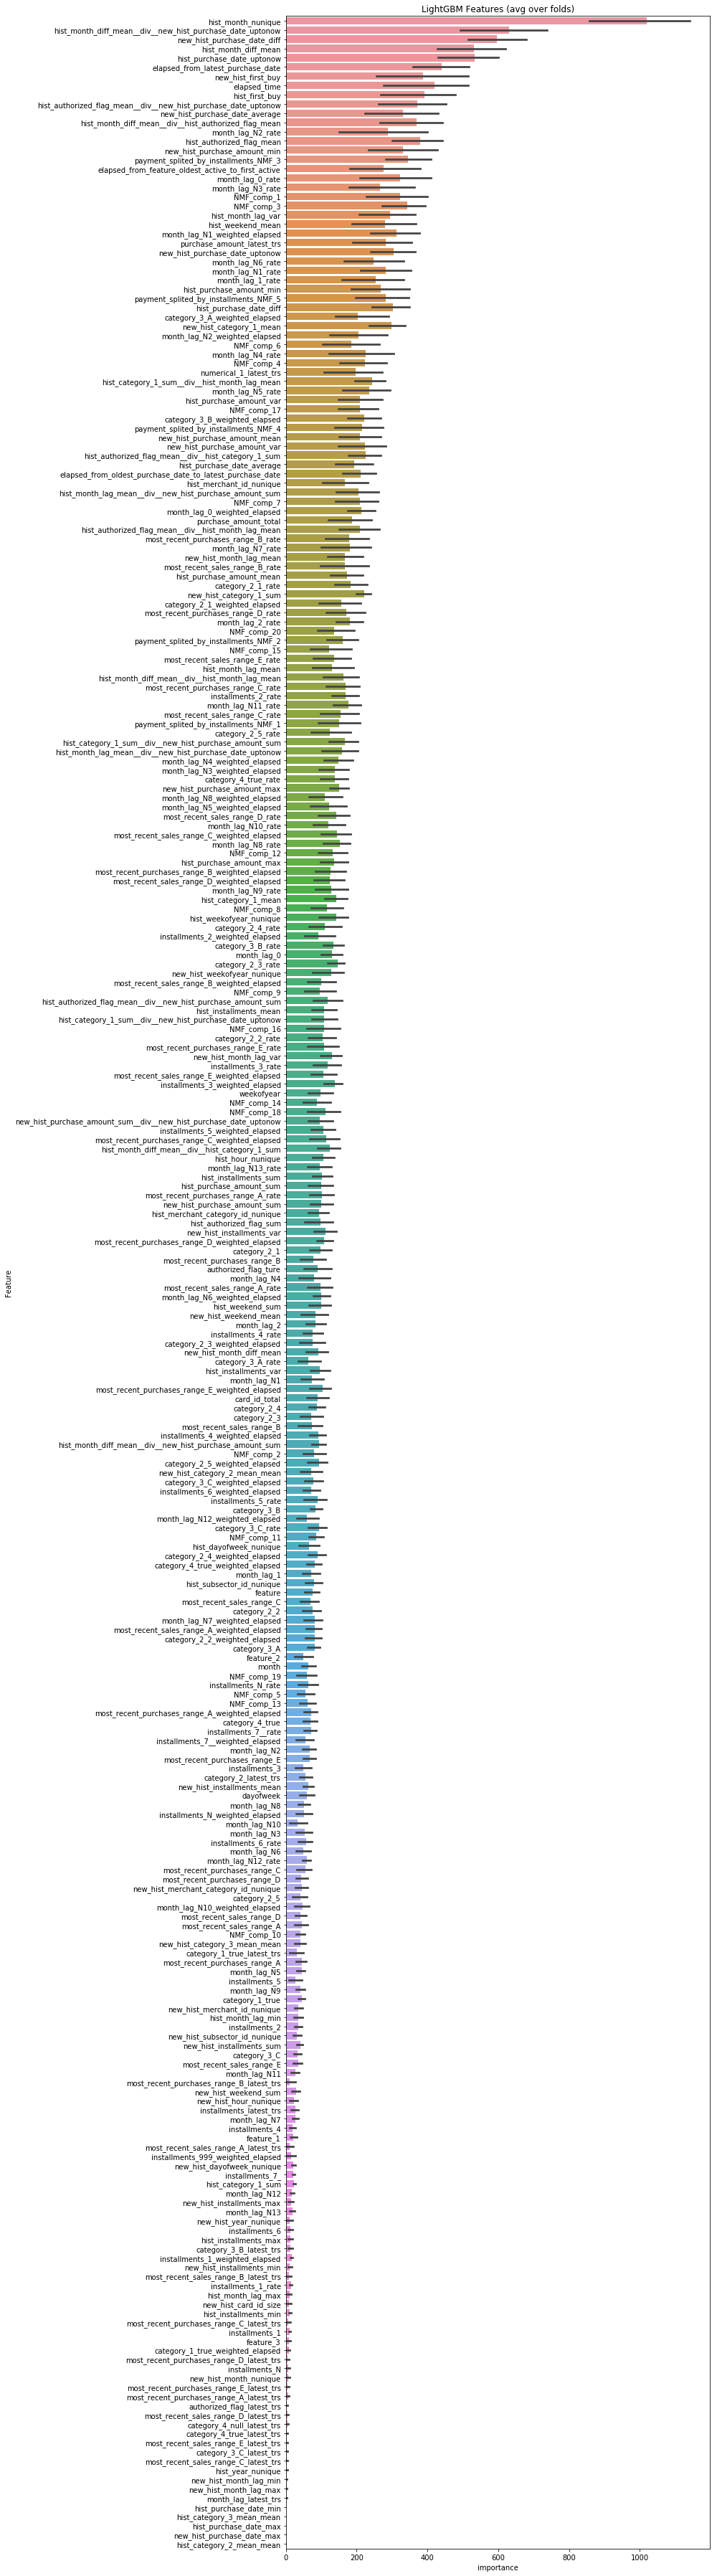

In [11]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [12]:
df_train_columns2 = cols[:200]

#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.909705	valid_1's auc: 0.896639
[200]	training's auc: 0.927758	valid_1's auc: 0.900973
[300]	training's auc: 0.938509	valid_1's auc: 0.904347
[400]	training's auc: 0.94822	valid_1's auc: 0.905231
[500]	training's auc: 0.956852	valid_1's auc: 0.90589
[600]	training's auc: 0.964299	valid_1's auc: 0.906294
[700]	training's auc: 0.96996	valid_1's auc: 0.905988
[800]	training's auc: 0.974233	valid_1's auc: 0.905341
[900]	training's auc: 0.977611	valid_1's auc: 0.904962
Early stopping, best iteration is:
[588]	training's auc: 0.963503	valid_1's auc: 0.906371
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.912347	valid_1's auc: 0.882998
[200]	training's auc: 0.929535	valid_1's auc: 0.888472
[300]	training's auc: 0.939638	valid_1's auc: 0.891328
[400]	training's auc: 0.949864	valid_1's auc: 0.893956
[500]	training's auc: 0.957444	valid_1's auc: 0.895018
[60

0.9018406934731391

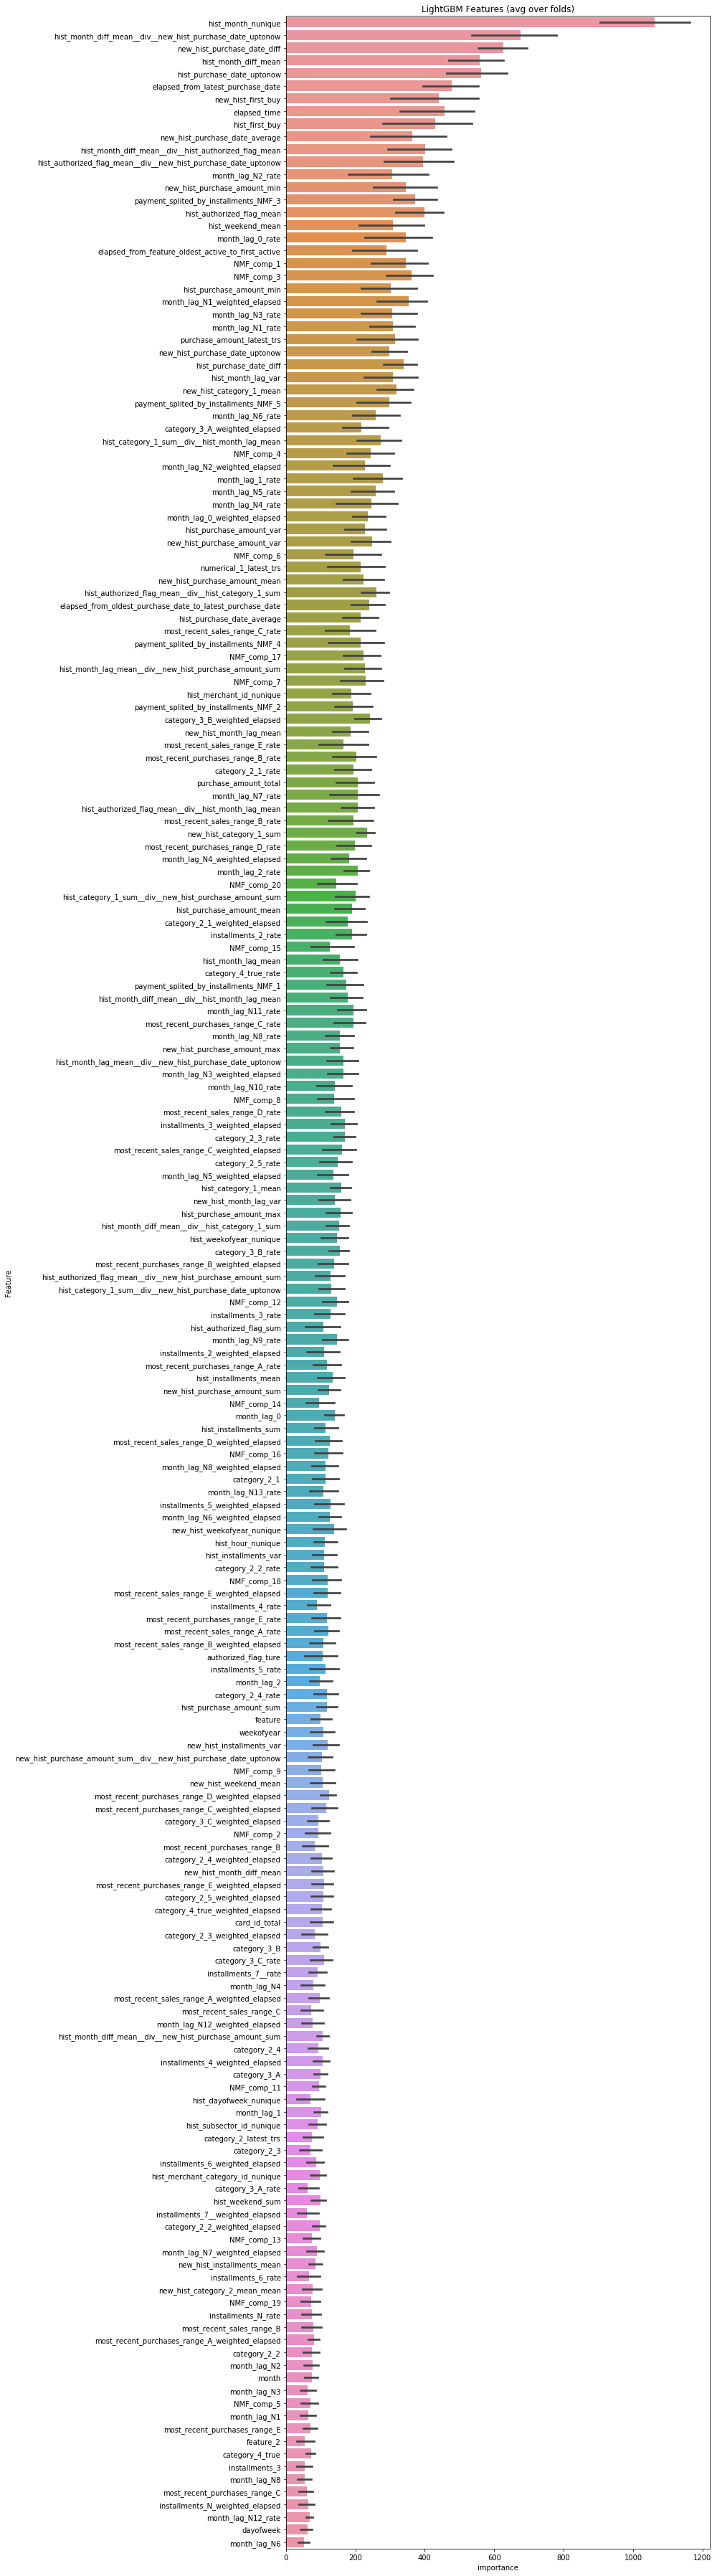

In [13]:
cols2 = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols2)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [14]:
df_oof = pd.DataFrame({"card_id":df_train.card_id, "outlier_prob":oof})
df_oof.to_csv("../input/outlier_clf_train_20180120.csv", index=False)

In [16]:
df_predict = pd.DataFrame({"card_id":df_test.card_id, "outlier_prob":predictions})
df_predict.to_csv("../input/outlier_clf_test_20180120.csv", index=False)